支持分离的mat格式的psf，转为numpy格式

In [ ]:
import scipy.io as sciio
import numpy as np

bg = sciio.loadmat("PSF_bk.mat")
psf_bk = np.float32(bg["psf_bk"])

psf = list()
for i in [1550,1560,1570,1580,1590,1600]:
    img = sciio.loadmat("PSF0620_{}_04_4_40.mat".format(i))
    psf.append(np.float32(img["PSF0"]))

psf = np.array(psf, dtype="float")
print(np.max(psf), np.min(psf))
psf /= (np.max(psf) - np.min(psf))
psf = psf - np.min(psf)
print(psf.shape, np.max(psf), np.min(psf))
np.save("PSF0620_04_4_40.npy", psf[:, 140:140+256, 210:210+256])
np.save("PSF0620_04_4_40_bg.npy", psf_bk[140:140+256, 210:210+256])


支持合并的mat格式的psf，转为numpy格式

(256, 256, 6)


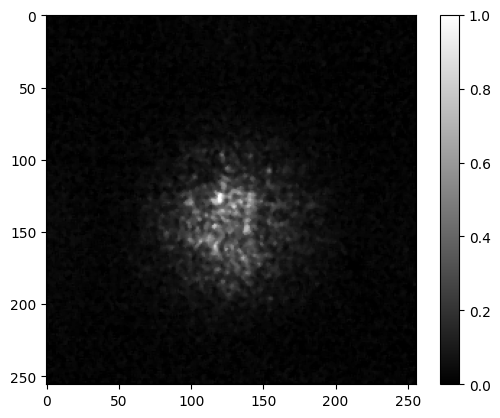

In [86]:
import scipy.io as sciio
import numpy as np
import matplotlib.pyplot as plt

coff = np.array([0.3227,0.3219,0.3208,0.3205,0.4532,0.4438])

psf_mat = sciio.loadmat("sup30/PSFset_Final.mat")
print(psf_mat["psf_set"].shape)
psf = psf_mat["psf_set"].transpose(2,0,1)
psf = np.array(psf, dtype="float")
psf = psf / coff.reshape(len(coff),1,1)

psf /= np.max(psf)
np.save("PSF0815_6_IR_30.npy",psf)


plt.imshow(psf[3,:,:] ,cmap="gray")
plt.colorbar()

显示图样psf图样

(6, 256, 256)
(256, 256)


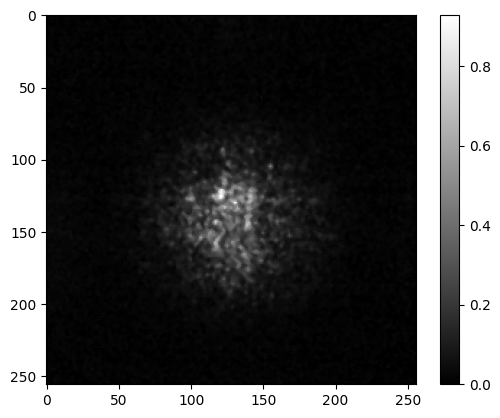

In [74]:
import matplotlib.pyplot as plt
import numpy as np 
psf = np.load("PSF0815_6_IR_30.npy")
psf_bg = np.load("PSF0620_04_4_40_bg.npy")
print(psf.shape)
print(psf_bg.shape)
plt.imshow(psf[5,:,:] ,cmap="gray")
plt.colorbar()

经过卷积之后的信噪比分析

In [ ]:
import sys
sys.path.insert(0, "../src")
import matplotlib.pyplot as plt
import numpy as np
from lib.utils.PointSample import gen_merge_sample
import cv2

def fft_calc(point_source_plan,otf_3d ):

    point_source_fft = np.fft.fft2(np.fft.ifftshift(point_source_plan,(1,2)))
    otf_fft = np.fft.fft2(np.fft.ifftshift(otf_3d,(1,2)))

    fft_dot = np.multiply(point_source_fft, otf_fft)
    
    point_image = np.fft.ifft2(fft_dot)
    point_image = np.fft.fftshift(point_image,(1,2))
    point_image_amp = np.abs(point_image)

    Intensity = np.sum(point_image_amp,0)

    return Intensity

psf = np.load("PSF0620_04_4_40.npy")
labels = [0,1,2,3,4,5]
obj_width = 5

sample, target = gen_merge_sample(psf, labels, obj_width, point_type="ones_rand", weight_mode = "rand", have_noise = True , noise_sig = 0.01, nsr = 0.1)

rect_patch = np.load("rect_patchs.npy")
num, h, w = rect_patch.shape
print(target)


rect_patch = rect_patch / np.max(rect_patch) * 255

wave=[1550,1560,1570,1580,1590,1600]

plt.figure()
fig, ax = plt.subplots(1,num)
for i in range(len(wave)):
    cv2.imwrite("rect_patch_{}.bmp".format(wave[i]), rect_patch[i, :, :])
    ax[i].imshow( rect_patch[i, :, :], cmap="gray")
plt.show()

sample /= np.max(sample)
cv2.imwrite("sample.bmp", sample[0, :, :]*255)



if False:

    print(psf.shape)
    psf = np.pad(psf,((0,0),(64,64),(64,64)))
    bg = np.zeros([num, 384, 384])
    bg[:, (192 - h // 2 - 1 ) : (192 + h // 2 ), (192 - w // 2 - 1) : (192 + w // 2)] = rect_patch

    point = np.zeros([num, 384, 384])

    for t in target:
        x = t[1]
        y = t[2]
        lenx = t[3]
        leny = t[4]
        point[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)] = bg[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)]
        bg[:, (y - leny//2 - 1):(y + leny//2),  (x - lenx//2 - 1):(x + lenx//2)] = 0


    a = point[0, (192 - h // 2 - 1 ) : (192 + h // 2 ), (192 - w // 2 - 1) : (192 + w // 2) ]
    plt.imshow(a, cmap="gray")
    cv2.imwrite("pt.bmp", a / np.max(a) * 255)

    rect_patch[:, (h//2 - 3): (h//2 + 2) , (w//2- 3 - 1) : (w//2 + 2) ] = 0
    b = rect_patch[0,:,:]
    cv2.imwrite("rect.bmp", b / np.max(b) * 255)
    plt.show()


    print(np.max(point), np.min(point))
    I_pt = fft_calc(point, psf)
    I_bg = fft_calc(bg, psf)
    print(np.max(I_pt))
    plt.imshow(I_pt, cmap="gray")
    plt.axis("off")
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=16) 
    plt.show()


    plt.imshow(I_bg, cmap="gray")
    plt.axis("off")
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=16) 
    plt.show()

    plt.imshow(I_pt +I_bg , cmap="gray")
    plt.colorbar()
    plt.show()


In [ ]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
rect_patch = np.load("rect_patchs.npy")
num, h, w = rect_patch.shape
print(rect_patch.shape)

rect_patch = rect_patch / np.max(rect_patch) * 255

wave=[1550,1560,1570,1580,1590,1600]


plt.imshow(rect_patch[2, :, :])

for i in range(len(wave)):
    cv2.imwrite("rect_patch_{}.bmp".format(wave[i]), rect_patch[i, :, :])

PSF相关性

In [1]:
import numpy as np
psf = np.load("PSF0815_6_IR_30.npy")
x = 64
psf = psf[:, (128 - x):(128 + x), (128 - x):(128 + x)]
psf = np.reshape(psf,(6, 4 * x * x))
coff = np.corrcoef(psf,rowvar=True)
np.savetxt("PSF0815_6_IR_30.txt", coff)
print(coff)
print(coff>0.9)

[[1.         0.75509524 0.86186559 0.84314299 0.72525098 0.94964566]
 [0.75509524 1.         0.75054992 0.81207042 0.7090134  0.75611182]
 [0.86186559 0.75054992 1.         0.81437249 0.67463986 0.84757517]
 [0.84314299 0.81207042 0.81437249 1.         0.70488637 0.84230544]
 [0.72525098 0.7090134  0.67463986 0.70488637 1.         0.71485008]
 [0.94964566 0.75611182 0.84757517 0.84230544 0.71485008 1.        ]]
[[ True False False False False  True]
 [False  True False False False False]
 [False False  True False False False]
 [False False False  True False False]
 [False False False False  True False]
 [ True False False False False  True]]


**背景数据转换格式**

SkyBK_1510To60_2023_08_16_XXXX.mat

sunny：
0028-0039
0056-0099

cloudy：
0000-0027
0040-0055

In [7]:
import scipy.io as sciio
import numpy as np


sunny_list = list(range(28,40)) + list(range(56,100))
cloudy_list = list(range(28)) + list(range(40,56))
coff = np.array([0.3227,0.3219,0.3208,0.3205,0.4532,0.4438])

sunny = []
for i in sunny_list:
    mat_file = "230816_1126/SkyBK_1510To60_2023_08_16_{:04d}.mat".format(i)
    sky = sciio.loadmat(mat_file)["SkyBK_MS"].transpose(2,0,1)       
    sky = np.array(sky, dtype=float)
    sky = sky / coff.reshape(len(coff), 1, 1)
    sky /= np.max(sky)
    sky = sky[:,::2, ::2]
    
    sunny.append(sky)
sunny_numpy = np.array(sunny,dtype=float)
print(sunny_numpy.shape)
print(np.mean(sunny_numpy,axis=(0,2,3)))

# np.save("sunny_sky_backgrouod.npy", sunny_numpy)


cloudy = []
for i in cloudy_list:
    mat_file = "230816_1126/SkyBK_1510To60_2023_08_16_{:04d}.mat".format(i)
    sky = sciio.loadmat(mat_file)["SkyBK_MS"].transpose(2,0,1)
    sky = np.array(sky, dtype=float)
    sky = sky / coff.reshape(len(coff), 1, 1)
    sky /= np.max(sky)
    sky = sky[:,::2, ::2]
    cloudy.append(sky)
cloudy_numpy = np.array(cloudy, dtype=float)
print(cloudy_numpy.shape)
print(np.mean(cloudy_numpy,axis=(0,2,3)))
# np.save("cloudy_sky_backgrouod.npy", cloudy_numpy)

(56, 6, 512, 640)
[0.31827714 0.37323706 0.38194509 0.77001127 0.5201971  0.58392762]
(44, 6, 512, 640)
[0.21817866 0.26760413 0.27464932 0.54645698 0.39334536 0.44284045]
